# Heuristic 2

## Imports

In [1]:
# Standard library imports
import time

# 3rd party imports
import numpy as np
np.set_printoptions(linewidth=2000, threshold=10000)
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pprint import pprint

# Importing custom modules
from modules import laplacian
from modules import jacobian
from modules import correspondences

## Functions

### Visualization

In [2]:
def plot_deformation(msample, fsample, deformation, title="", figsize=(20, 10), show_values=True, show_points=True):
    """
    Plots the deformation field between two sets of points.
    """
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    # Calculate the Jacobian determinant
    J = np.squeeze(jacobian.sitk_jacobian_determinant(deformation))
    num_neg_J = np.sum(J <= 0)
    norm = mcolors.TwoSlopeNorm(vmin=min(J.min(), J.min(), -3), vcenter=0, vmax=max(J.max(), J.max(), 3))

    # Draw lines connecting the points in the first subplot
    for i in range(len(msample)):  # Draw lines connecting the points
        axs[0].annotate(
            '', 
            xy=(fsample[i][2], fsample[i][1]), 
            xytext=(msample[i][2], msample[i][1]), 
            arrowprops=dict(facecolor='black', shrink=0.045, headwidth=8, headlength=10, width=3)
        )
    
    # Create a grid of points
    x, y = np.meshgrid(range(deformation.shape[3]), range(deformation.shape[2]), indexing='xy')

    # Plot the initial points and Jacobian determinant scores
    im = axs[0].imshow(J, cmap='seismic', norm=norm)
    axs[0].set_title(f"Jacobian determinant grid\n({num_neg_J} negative Jacobian values)")
    
    axs[0].set_xticks(np.arange(0, deformation.shape[3], 1))
    axs[0].set_yticks(np.arange(0, deformation.shape[2], 1))

    if show_values:
        # Add text for the values
        for i in range(J.shape[0]):
            for j in range(J.shape[1]):
                axs[0].text(j, i, f"{J[i, j]:.2f}", ha="center", va="center", color="black", fontsize=8)
        
        for i in range(J.shape[0]):
            for j in range(J.shape[1]):
                axs[1].text(j, i + 0.3, f"{J[i, j]:.2f}", ha="center", va="center", color="black", fontsize=8)

    # Plot the deformation vectors
    axs[1].set_title(f"Deformation vector field")
    axs[1].imshow(J, cmap='seismic', norm=norm)
    axs[1].quiver(x, y, deformation[2,0], deformation[1,0])
    
    axs[1].set_xticks(np.arange(0, deformation.shape[3], 1))
    axs[1].set_yticks(np.arange(0, deformation.shape[2], 1))
    
    if show_points:
        axs[0].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
        axs[0].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
        axs[0].legend()
        axs[1].scatter(msample[:, 2], msample[:, 1], c='g', label='Moving')
        axs[1].scatter(fsample[:, 2], fsample[:, 1], c='violet', label='Fixed')
        axs[1].legend()
    
    # Add colorbar
    #cbar_ax = fig.add_axes([0.94, 0.15, 0.015, 0.7])
    #cbar = fig.colorbar(im, cax=cbar_ax)
    #cbar.set_label('Jacobian determinant')
    
    # Draw very light grid lines between moving and fixed points
    for i in range(len(msample)):
        axs[1].plot(
            [msample[i][2], fsample[i][2]],
            [msample[i][1], fsample[i][1]],
            color='gray',
            linestyle='--',
            linewidth=1,
            alpha=0.5,
            zorder=1
        )
    
    # Invert y-axes
    axs[0].invert_yaxis()
    axs[1].invert_yaxis()
    
    # Set titles
    fig.suptitle(title, fontsize=16)
    
    # Add colorbar that matches the height of the axes
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes("right", size="5%", pad=0.15)
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label('Jacobian determinant')
    
    plt.tight_layout()
    plt.show()

### Heuristic

In [3]:
def average_vector_excluding_center(patch, center_idx):
    """
    Given a patch of shape (3, 3, 3) or flattened (3, 9), compute the average vector
    excluding the vector at center_idx.
    """
    patch_flat = patch.reshape(3, -1)
    patch_wo_center = np.delete(patch_flat, center_idx, axis=1)
    avg_vec = np.mean(patch_wo_center, axis=1)
    return avg_vec

def get_3x3_vector_patch(deformation, y, x):
    """
    Given a deformation field of shape (3, y_dim, x_dim, ...), 
    return a 3x3x3 patch centered at (y, x) for the first slice (if 4D).
    deformation: numpy array of shape (3, y_dim, x_dim) or (3, 1, y_dim, x_dim)
    x, y: center coordinates (int)
    Returns: numpy array of shape (3, 3, 3)
    """
    y_dim, x_dim = deformation.shape[2], deformation.shape[3]

    x_start = min(max(x - 1, 0), x_dim - 3)
    x_end = x_start + 3
    y_start = min(max(y - 1, 0), y_dim - 3)
    y_end = y_start + 3
    
    patch = deformation[:, 0, y_start:y_end, x_start:x_end]
    patch = patch[:, :3, :3]

    idx_center = (y - y_start) * 3 + (x - x_start)
    # idx_center is the index of the center vector in the flattened patch
    avg_vec = average_vector_excluding_center(patch, idx_center)

    return patch, avg_vec

In [4]:
def heuristic_negative_jacobian_correction(deformation, msample, fsample,
                                           show_values=True, show_points=True):
    """ 
    Heuristic to correct negative Jacobian values in a deformation field.
    
    deformation: numpy array of shape (3, 1, y_dim, x_dim)
    msample: numpy array of shape (n, 3) for moving sample points
    fsample: numpy array of shape (n, 3) for fixed sample points
    """
    deformation_copy = deformation.copy()
    # Get the coordinates of all negative Jacobian values
    J = np.squeeze(jacobian.sitk_jacobian_determinant(deformation_copy))
    neg_coords = np.argwhere(J < 0)
    #print("Negative Jacobian coordinates:")
    #pprint(neg_coords)

    plot_deformation(msample, fsample, deformation_copy, 
                    title="Initial deformation field", figsize=(20, 10), 
                    show_values=show_values, show_points=show_points)

    # At each negative Jacobian coordinate, replace the adjacent pixels around it 
    # with the average 3x3 neighborhood vector
    for coord in neg_coords:
        y, x = coord
        
        # Replace the pixels around the vector with the average vector
        pixels_around = [
            (y-1, x-1), (y-1, x), (y-1, x+1),
            (y, x-1), (y, x), (y, x+1),
            (y+1, x-1), (y+1, x), (y+1, x+1)
        ]
        # Ensure we stay within bounds
        pixels_around = [(py, px) for py, px in pixels_around 
                        if 0 <= py < deformation_copy.shape[2] and 0 <= px < deformation_copy.shape[3]]
        
        # Get the 3x3 patch centered at each (py, px) and replace the target vector with the average vector
        for py, px in pixels_around:
            patch, avg_vec = get_3x3_vector_patch(deformation_copy, py, px)
            deformation_copy[:, 0, py, px] = avg_vec
            
    # Plot the updated deformation field after applying the heuristic
    plot_deformation(msample, fsample, deformation_copy, 
                    title="Modified deformation field", figsize=(20, 10), 
                    show_values=show_values, show_points=show_points)
        
    # Recompute the Jacobian determinant and update the negative Jacobian coordinates
    J = np.squeeze(jacobian.sitk_jacobian_determinant(deformation_copy))
    neg_coords = np.argwhere(J < 0)

    # Print the number of remaining negative Jacobian coordinates and the errors
    print(f"Updated negative Jacobian coordinates: {neg_coords.shape[0]} remaining")
    return deformation_copy


def compute_error(deformation, modified_deformation, show=True):
    """
    Compute the L1 and L2 errors between the original and modified deformation fields.
    """
    l1_error = np.sum(np.abs(deformation - modified_deformation))
    l2_error = np.sqrt(np.sum((deformation - modified_deformation) ** 2))
    if show:
        print(f"L1 error: {l1_error:.4f}, L2 error: {l2_error:.4f}")
    return l1_error, l2_error

## Create deformation field cases

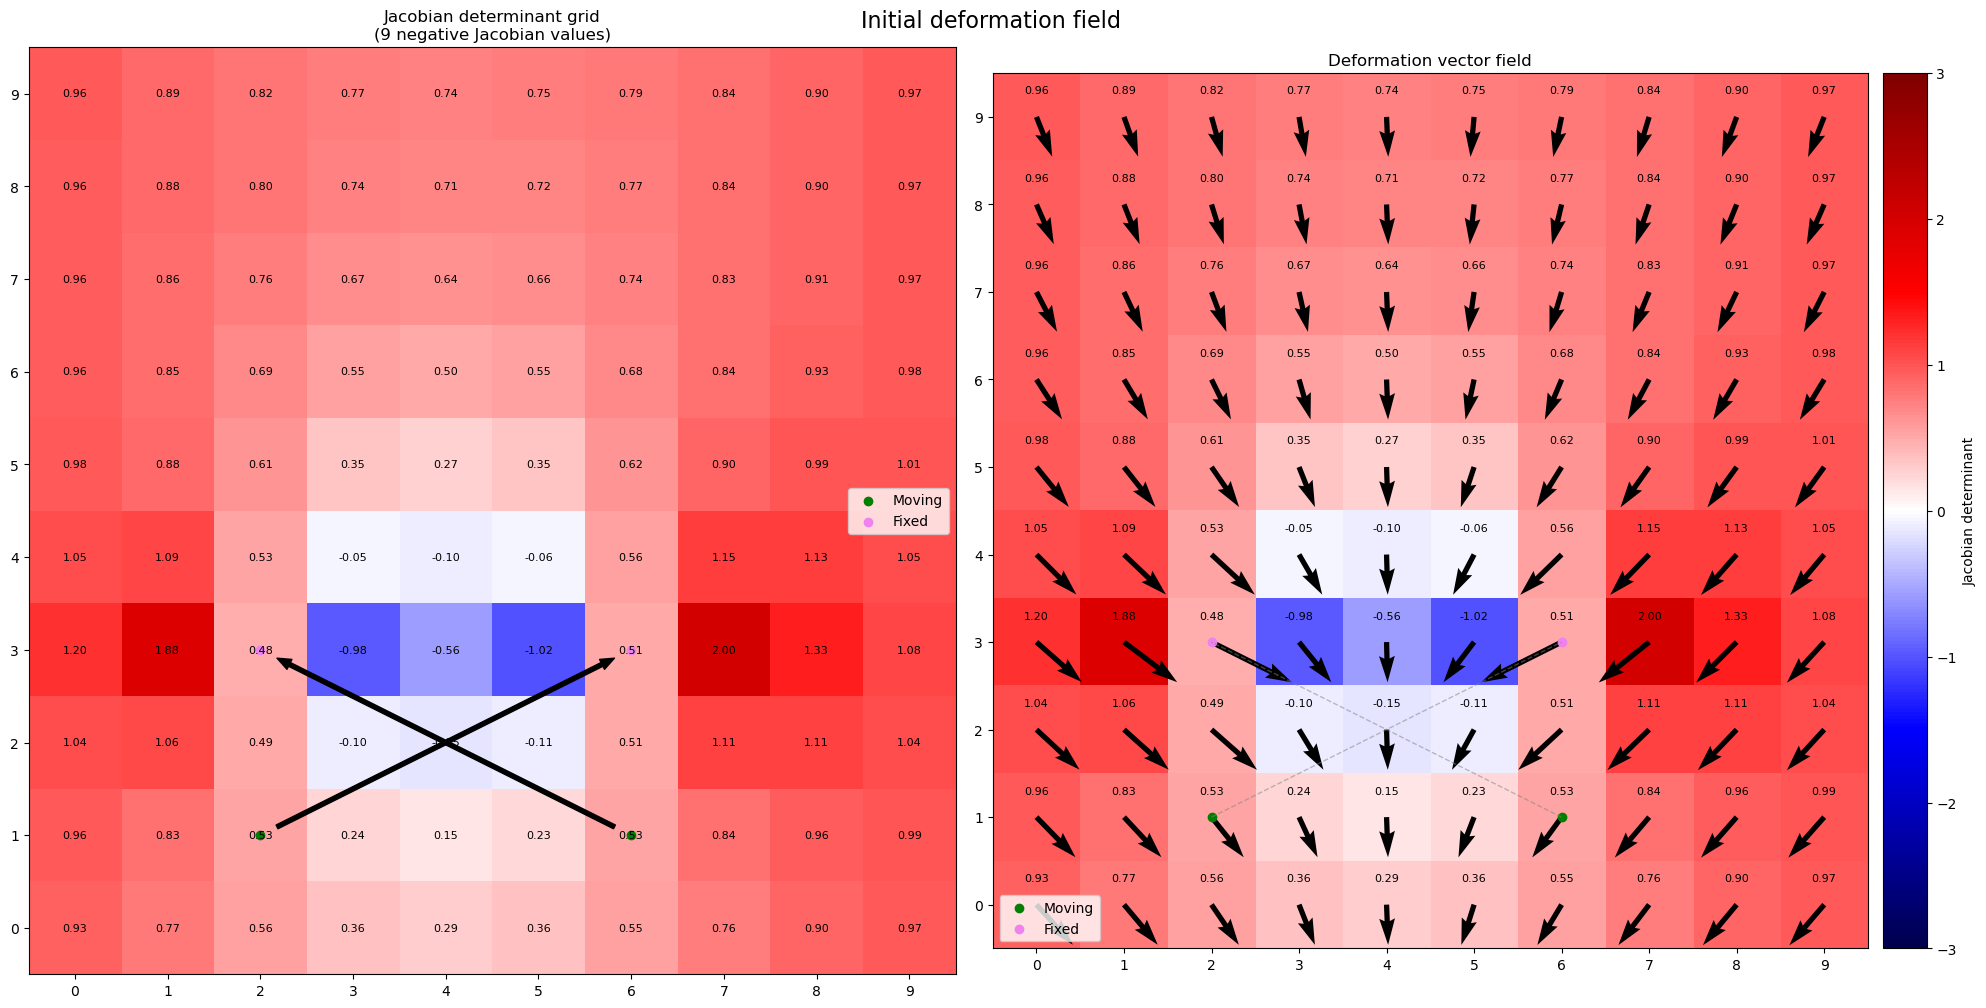

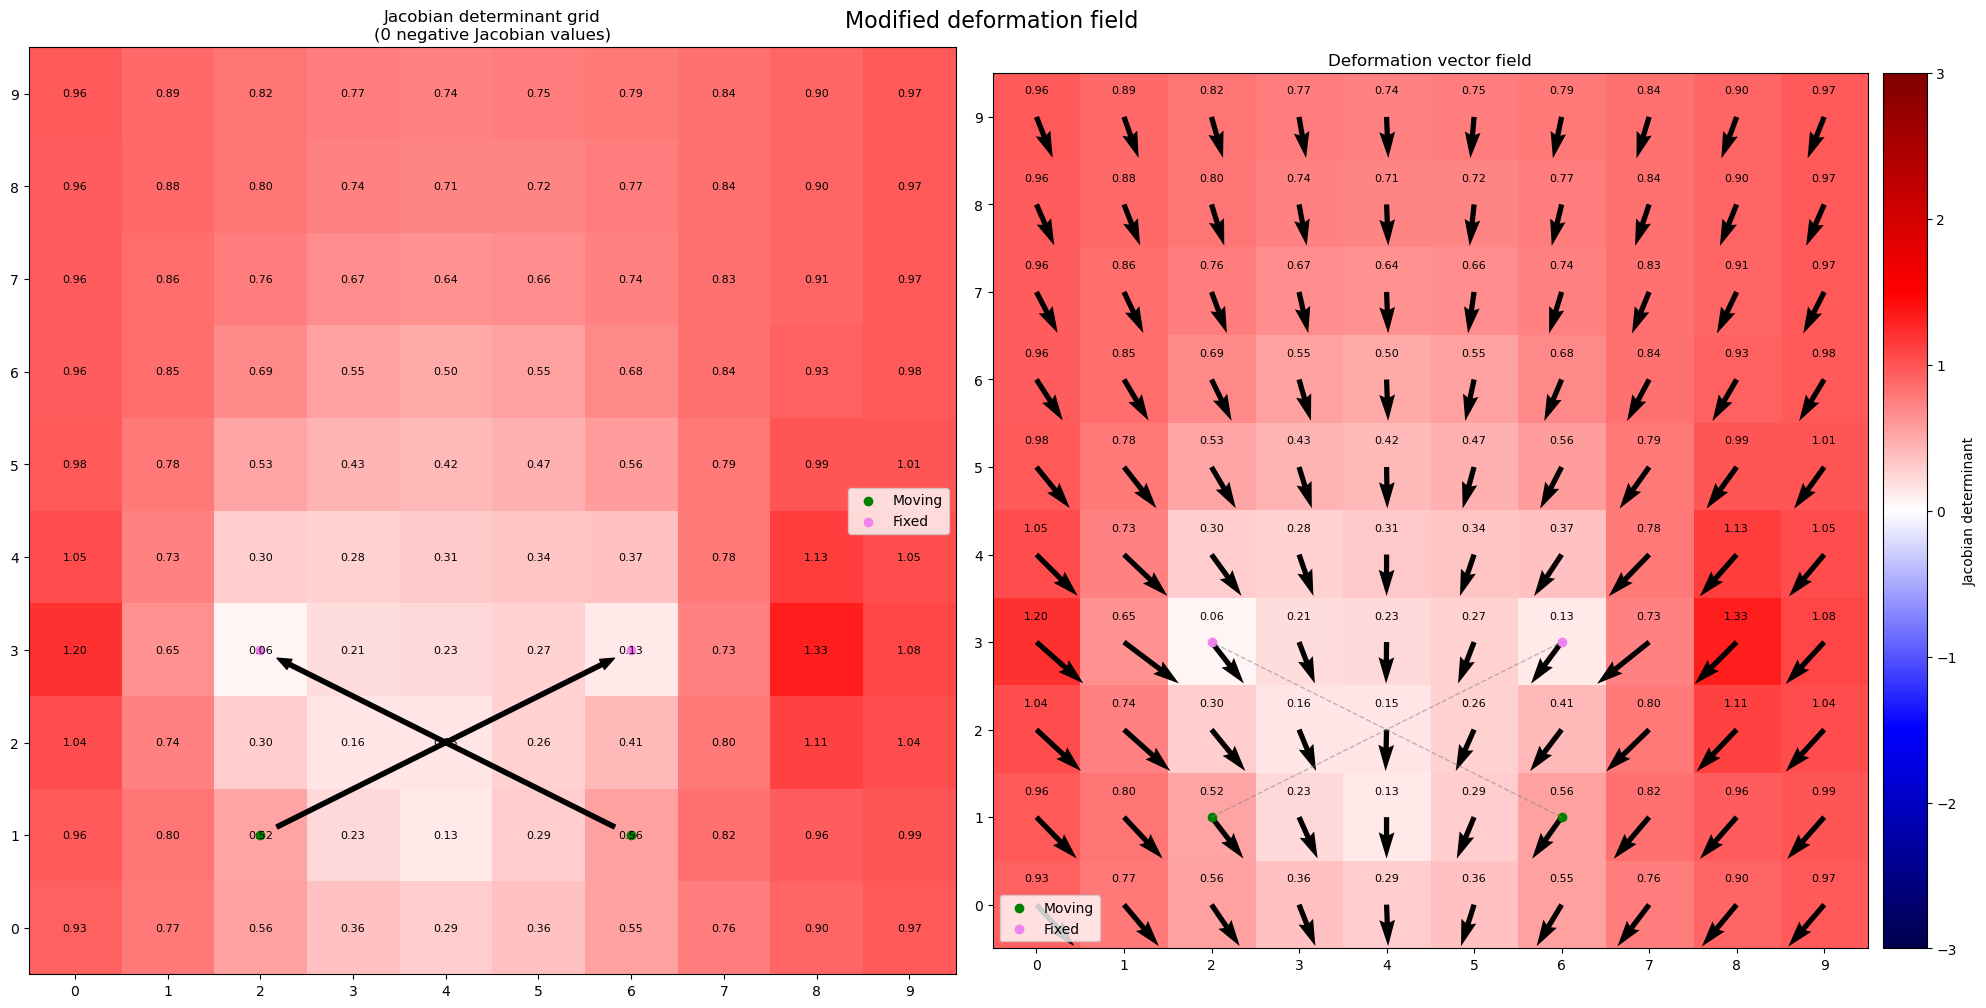

Updated negative Jacobian coordinates: 0 remaining
L1 error: 11.9553, L2 error: 4.0198

Total elapsed time: 1.02 seconds


In [5]:
# Create a sample moving and fixed point set
msample = np.array([
    [0, 1, 2],
    [0, 1, 6],
])
fsample = np.array([
    [0, 3, 6],
    [0, 3, 2],
])
fixed_sample = np.zeros((1, 10, 10))

show_values = True
show_points = True

# Create a deformation field with Laplacian and apply the heuristic
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Start the timer for the heuristic correction
start_time = time.time()
modified_deformation = heuristic_negative_jacobian_correction(deformation, msample, fsample,
                                                              show_values=show_values, show_points=show_points)
# Compute the error between the original and modified deformation fields
l1_error, l2_error = compute_error(deformation, modified_deformation, show=True)

# Do it again until zero negative Jacobian values are reached
num_neg_J = np.sum(np.squeeze(jacobian.sitk_jacobian_determinant(modified_deformation)) <= 0)
iter = 1
while num_neg_J > 0:
    print(f"\nIteration {iter + 1}: correcting negative Jacobian values...")
    print(f"Number of negative Jacobian values: {num_neg_J}")
    modified_deformation = heuristic_negative_jacobian_correction(modified_deformation, msample, fsample,
                                                                  show_values=show_values, show_points=show_points)
    l1_error, l2_error = compute_error(deformation, modified_deformation, show=True)
    num_neg_J = np.sum(np.squeeze(jacobian.sitk_jacobian_determinant(modified_deformation)) <= 0)
    
# Recap the total elapsed time
elapsed_time = time.time() - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")

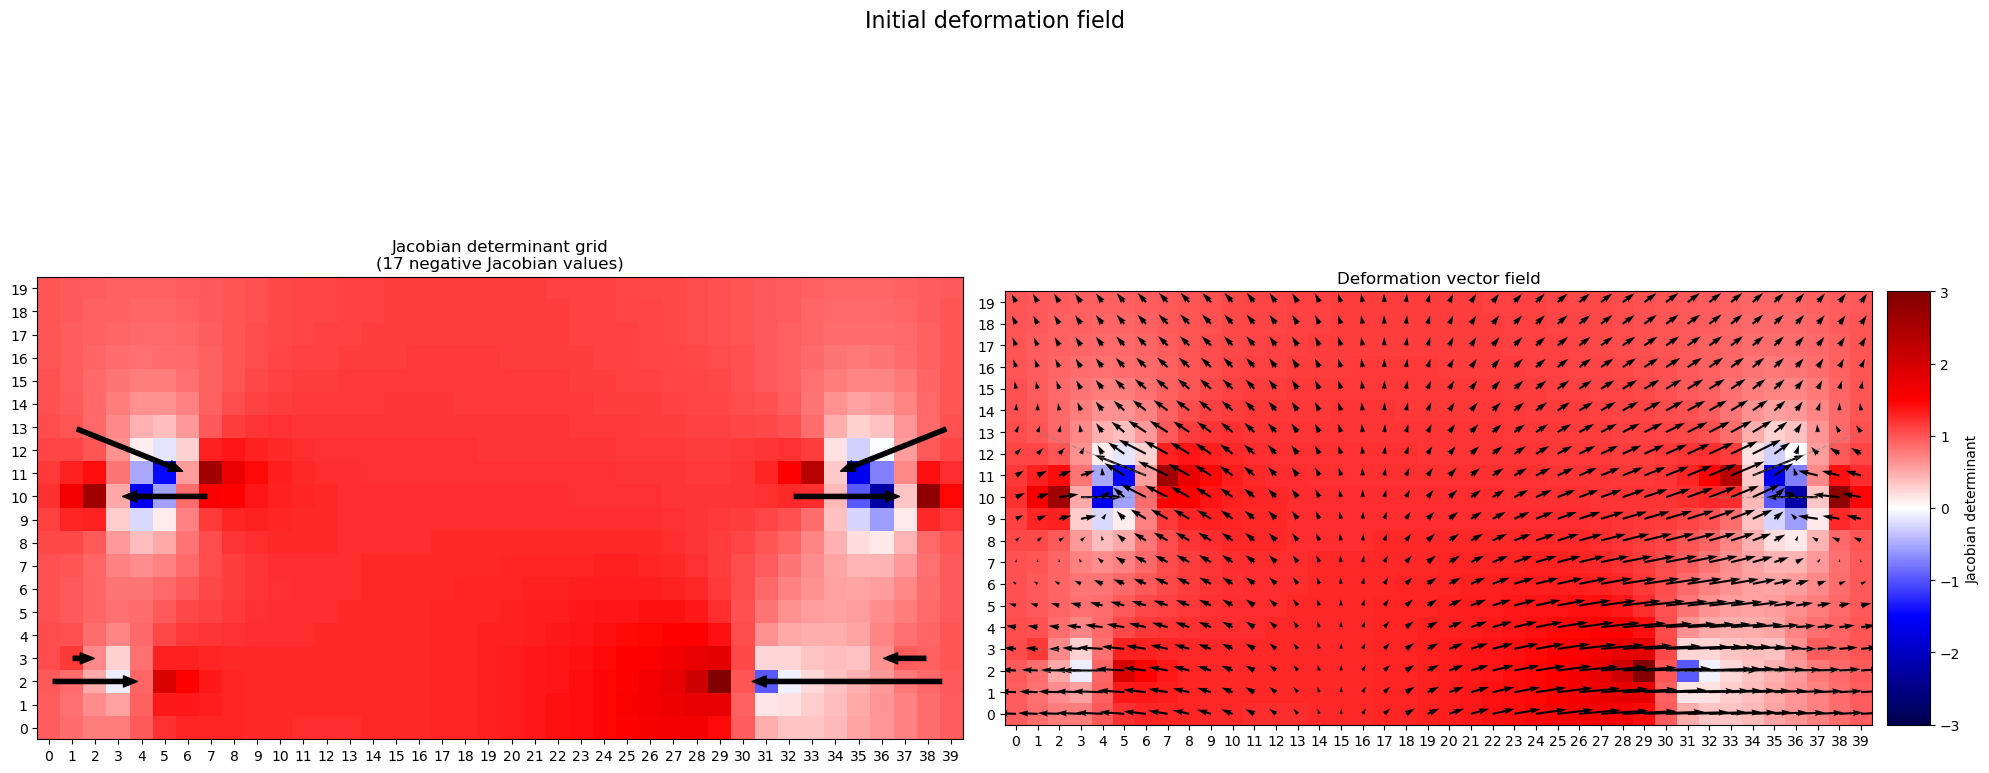

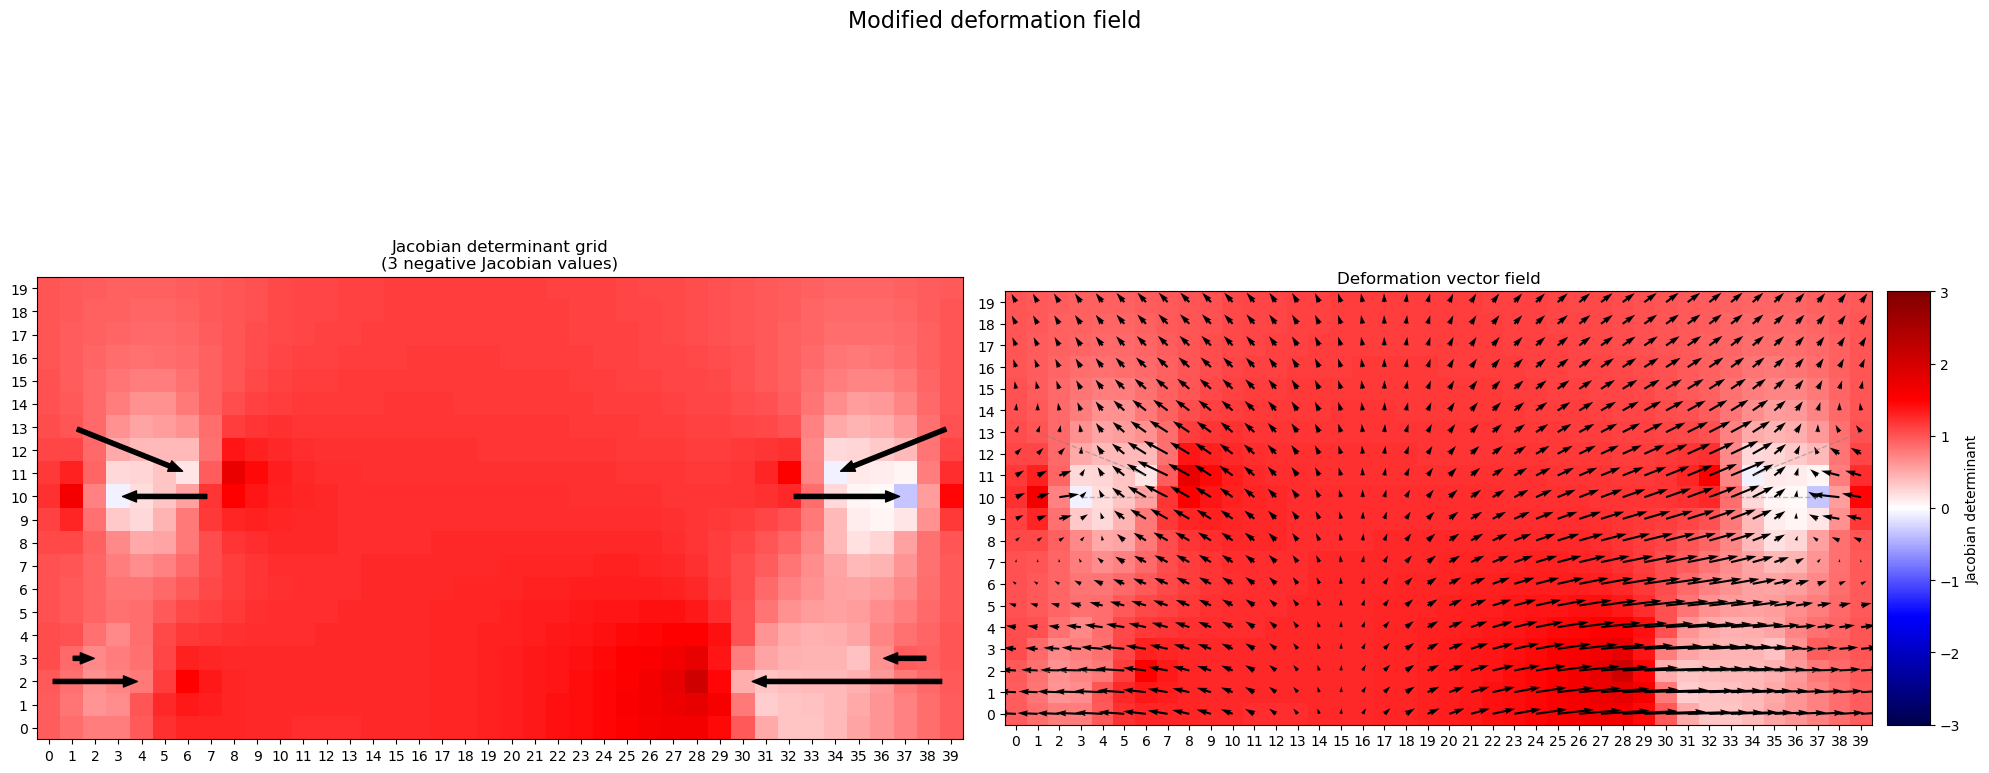

Updated negative Jacobian coordinates: 3 remaining
L1 error: 47.3720, L2 error: 8.7941

Iteration 2: correcting negative Jacobian values...
Number of negative Jacobian values: 3


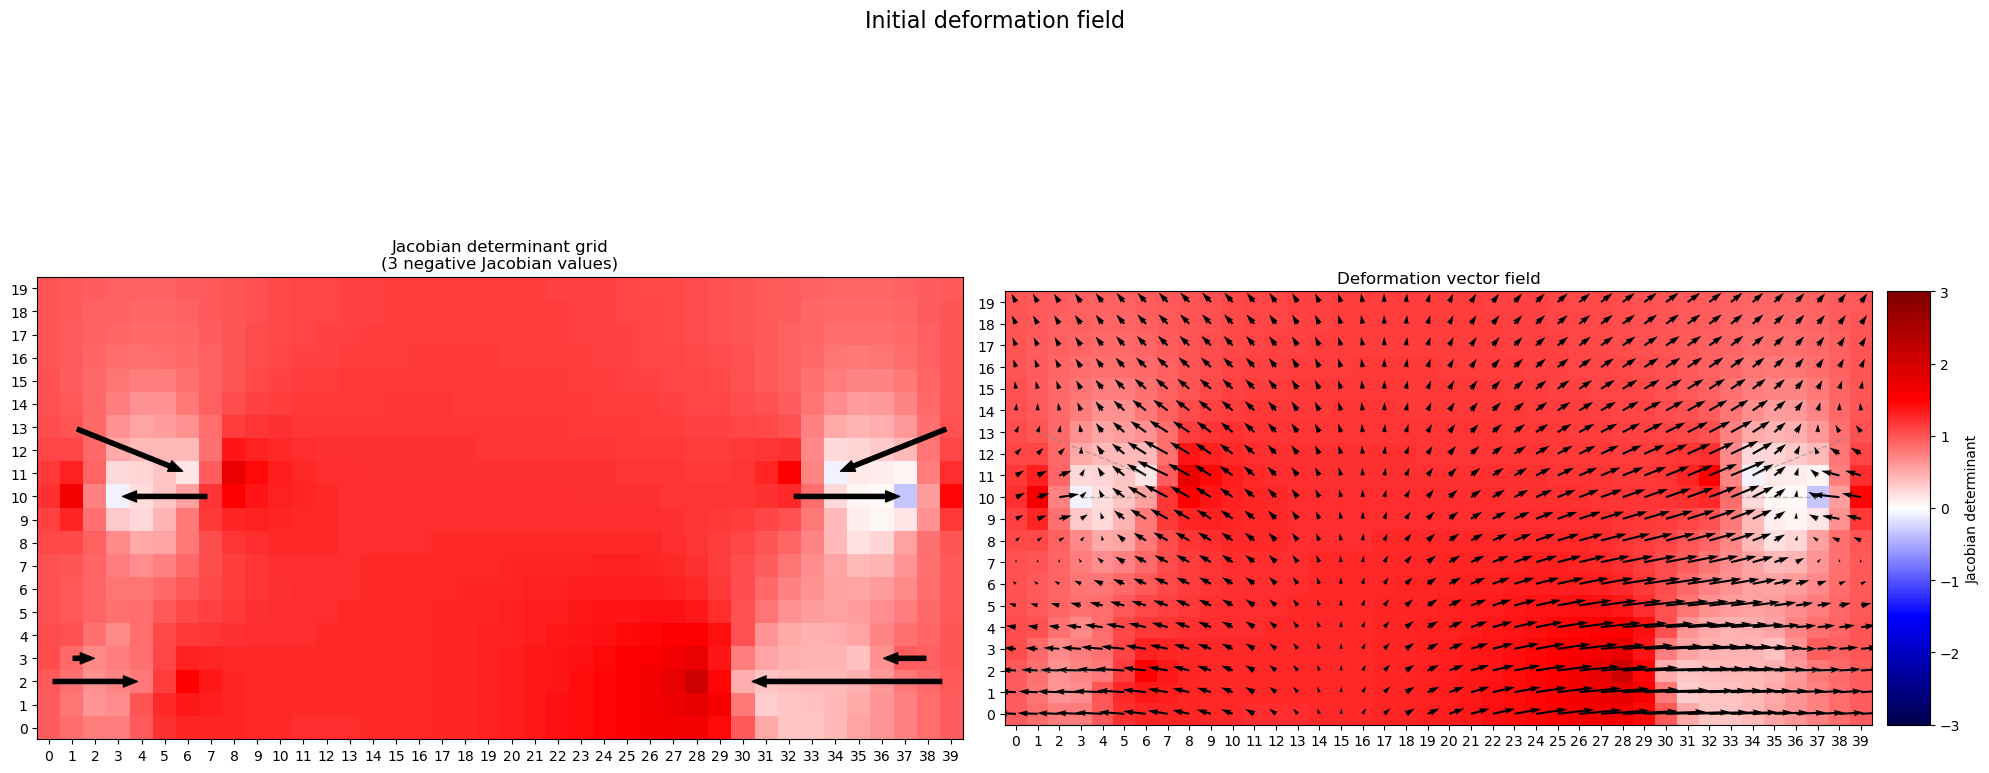

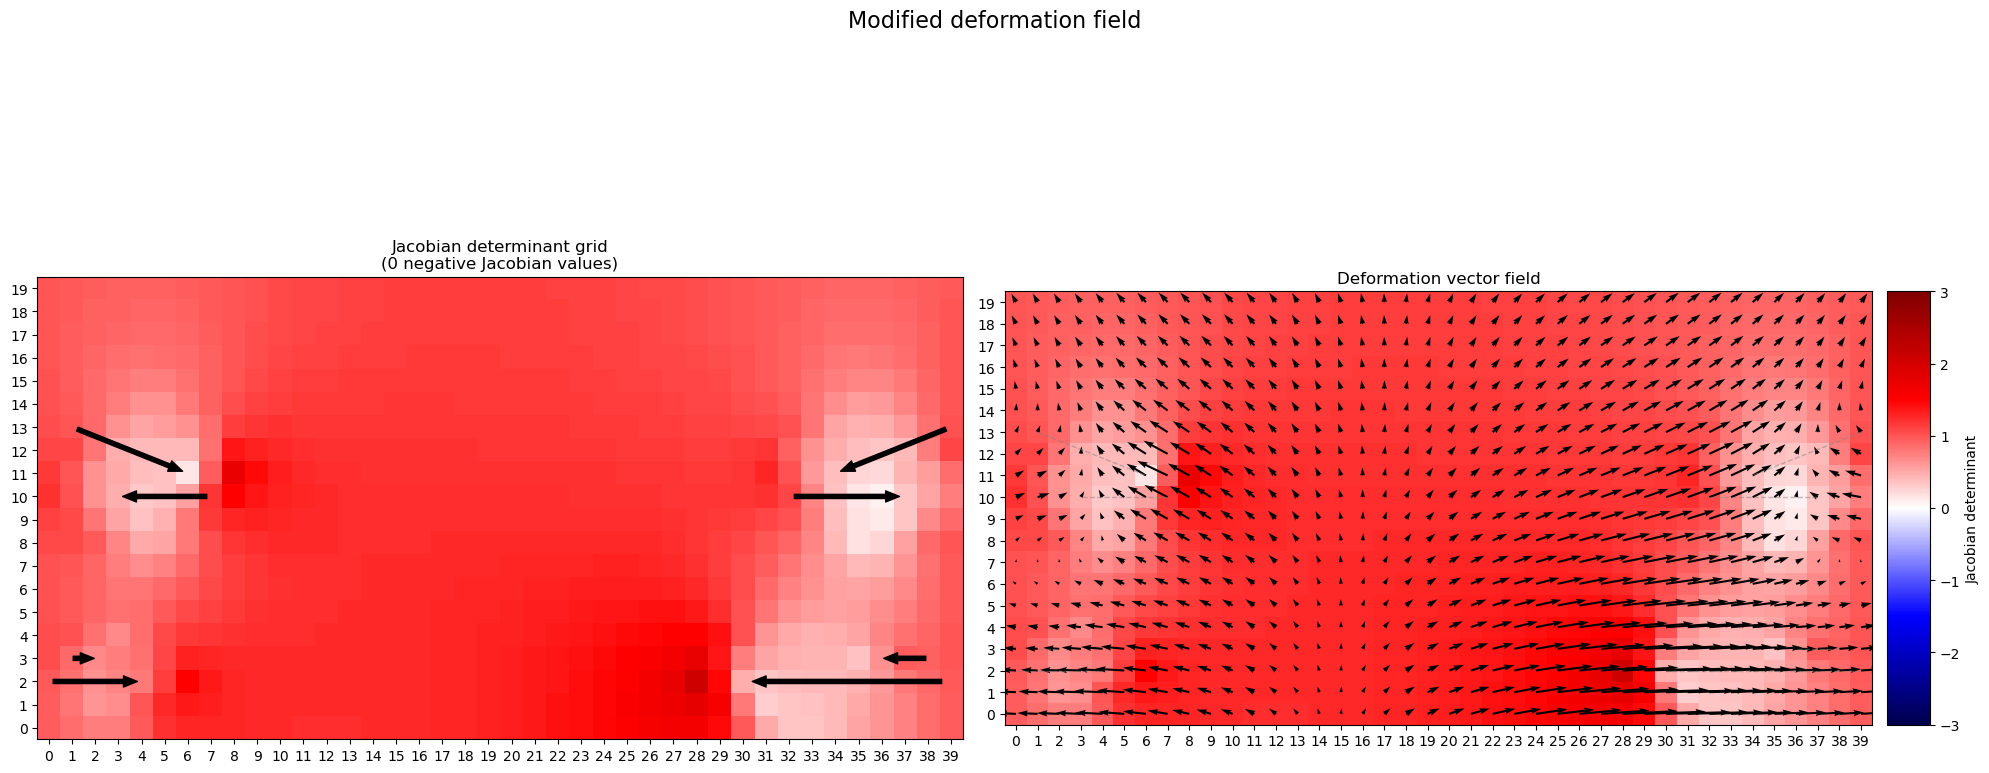

Updated negative Jacobian coordinates: 0 remaining
L1 error: 57.3297, L2 error: 9.4830

Total elapsed time: 1.57 seconds


In [6]:
# Create a sample moving and fixed point set
msample = np.array([
    [0, 2, 0],
    [0, 3, 1],
    [0, 10, 7],
    [0, 13, 1],
    [0, 2, 39],
    [0, 3, 38],
    [0, 10, 32],
    [0, 13, 39],
])
fsample = np.array([
    [0, 2, 4],
    [0, 3, 2],
    [0, 10, 3],
    [0, 11, 6],
    [0, 2, 30],
    [0, 3, 36],
    [0, 10, 37],
    [0, 11, 34]
])
fixed_sample = np.zeros((1, 20, 40))

show_values = False
show_points = False

# Create a deformation field with Laplacian and apply the heuristic
deformation, A, Zd, Yd, Xd = laplacian.sliceToSlice3DLaplacian(fixed_sample, msample, fsample)

# Start the timer for the heuristic correction
start_time = time.time()
modified_deformation = heuristic_negative_jacobian_correction(deformation, msample, fsample,
                                                              show_values=show_values, show_points=show_points)
l1_error, l2_error = compute_error(deformation, modified_deformation, show=True)

# Do it again until zero negative Jacobian values are reached
num_neg_J = np.sum(np.squeeze(jacobian.sitk_jacobian_determinant(modified_deformation)) <= 0)
iter = 1
while num_neg_J > 0:
    print(f"\nIteration {iter + 1}: correcting negative Jacobian values...")
    print(f"Number of negative Jacobian values: {num_neg_J}")
    modified_deformation = heuristic_negative_jacobian_correction(modified_deformation, msample, fsample,
                                                                  show_values=show_values, show_points=show_points)
    l1_error, l2_error = compute_error(deformation, modified_deformation, show=True)
    num_neg_J = np.sum(np.squeeze(jacobian.sitk_jacobian_determinant(modified_deformation)) <= 0)
    
# Recap the total elapsed time
elapsed_time = time.time() - start_time
print(f"\nTotal elapsed time: {elapsed_time:.2f} seconds")